In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import optimize

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

In [14]:
steps = 100 # Dimensions of calculated values in 1- and 2-D arrays 

slope_min = 0.1 # Minimum slope angle, dregrees
slope_max = 30 # Maximum slope angle, dregrees

slope_deg_array = np.linspace(slope_min,slope_max,steps) # Range of slopes

flow_speed_list = np.logspace(-5,1, steps)


In [15]:
frozen_grad = 10

unfrozen_grad = 30

x_t = 1600

porosity = 0.9

In [16]:
# beta_list = list(np.logspace(-1,-5,10)*3) + [0.]
beta_list = [0.04]

wavelength_beta_list = []

sigma_max_beta_list = []

In [17]:
def get_wavelength(RHS, Q_bar_calc):

    """Numerically solves for kappa and then wavelength
    """
    def f(kappa):

        LHS_num = kappa**(8/3)

        LHS_den = (kappa**2 + ((C_f*rho_f*(Q_bar_calc-(beta*unfrozen_grad)))/(K_f*rho_w*L_curly)))**(0.5)

        LHS = LHS_num / LHS_den

        
        return LHS - RHS


    try:
        sol = optimize.root_scalar(f, bracket=[
            RHS**(3/5), # Keeps it the "right" solution
              3e2], method='brentq')
        wavelength = 2*3.1415/sol.root
    except ValueError:
        # print(f'No solution > RHS**(3/5) when RHS ={RHS}')
        wavelength = np.nan

    return wavelength

# Hide me

Constants

In [18]:
# Constants
rho_w = 1000 # kg m^3 
rho_s = 2600
rho_i = 900

C_w = 4184 # J K-1 kg-1 
C_s = 700 
C_i = 2050

K_w = 0.598 # W/m·K 
K_s = 1.460 * 5
K_i = 2.220

g = 9.8
visc = 8.9E-4
rho_l = 1000


Derived things sensitive to porosity

In [19]:
rho_u = rho_s*(1-porosity) + (rho_w * porosity)
rho_f = rho_s*(1-porosity) + (rho_i * porosity)

C_u = C_s*(1-porosity) + (C_w * porosity)
C_f = C_s*(1-porosity) + (C_i * porosity)

K_u = K_s*(1-porosity) + (K_w * porosity)
K_f = K_s*(1-porosity) + (K_i * porosity)
slope = np.tan(np.deg2rad(slope_deg_array))

# diam = 0.00005 # m, diameter of grains of matrix

# L_curly = 334  # Latent head of fusion modulated by porosity
L_curly = 334E3 * porosity # Latent head of fusion modulated by porosity

# # Kozeny–Carman equation for laminar flow, assume spherical particles
# perm_ck = (porosity**3 * diam**2) / (180 * ((1-porosity)**2))

# hyd_cond = (perm_ck * g * rho_w) / visc

C_f = C_s*(1-porosity) + (C_i * porosity)

K_f = K_s*(1-porosity) + (K_i * porosity)


Toolik flow parameters

In [20]:
discharge_june = (11.06 / 1000) # max discharge with minimum thaw L/s converted to m3/s
discharge_aug = (0.25 / 1000) # "average" discharge with max thaw L/s convervted to m3/s, kind of eyeballed

depth_june = 0.10 # m, Based on field data
depth_aug = 0.70 # m, Based on field data

wt_width = 8 

flow_speed_june = discharge_june / (depth_june * wt_width) # x-sec area of wt vs discharge in m3/s

flow_speed_aug = discharge_aug / (depth_aug * wt_width) # x-sec area of wt vs discharge in m3/s

# Mesh slope, hydraulic conductivity, and solve for wavelength for the list of betas

In [21]:
# Mesh the two axes
ss, hh = np.meshgrid(np.tan(np.deg2rad(slope_deg_array)), flow_speed_list)

# Calculate Q_bar, which is based on both
Q_bar_calc = (hh * rho_w * g * ss)

# Make thermal constants in the right shape 
C_f_arr = np.broadcast_to(C_f, np.shape(Q_bar_calc))
K_f_arr = np.broadcast_to(K_f, np.shape(Q_bar_calc))



In [22]:
for i, beta in enumerate(beta_list):

    sigma_max = (1/(rho_w*porosity*L_curly)) * (Q_bar_calc - (beta * unfrozen_grad))
    sigma_max_beta_list.append(sigma_max)


    RHS = (2.0374 * (Q_bar_calc)) / (x_t**(2/3) * (K_f * frozen_grad))

    wavelength = np.empty_like(Q_bar_calc)

    for i in range(np.shape(wavelength)[0]):
        for j in range(np.shape(wavelength)[1]):
            wavelength[i, j] = get_wavelength(RHS[i,j], Q_bar_calc[i,j])

    wavelength_beta_list.append(wavelength)

C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_8352\1597931246.py:9: RuntimeWarning: invalid value encountered in scalar power
  LHS_den = (kappa**2 + ((C_f*rho_f*(Q_bar_calc-(beta*unfrozen_grad)))/(K_f*rho_w*L_curly)))**(0.5)


# Don't hide me

In [23]:
#Pick only a single beta to plot
beta_index = -1
wavelength = wavelength_beta_list[beta_index]
sigma_max = sigma_max_beta_list[beta_index]


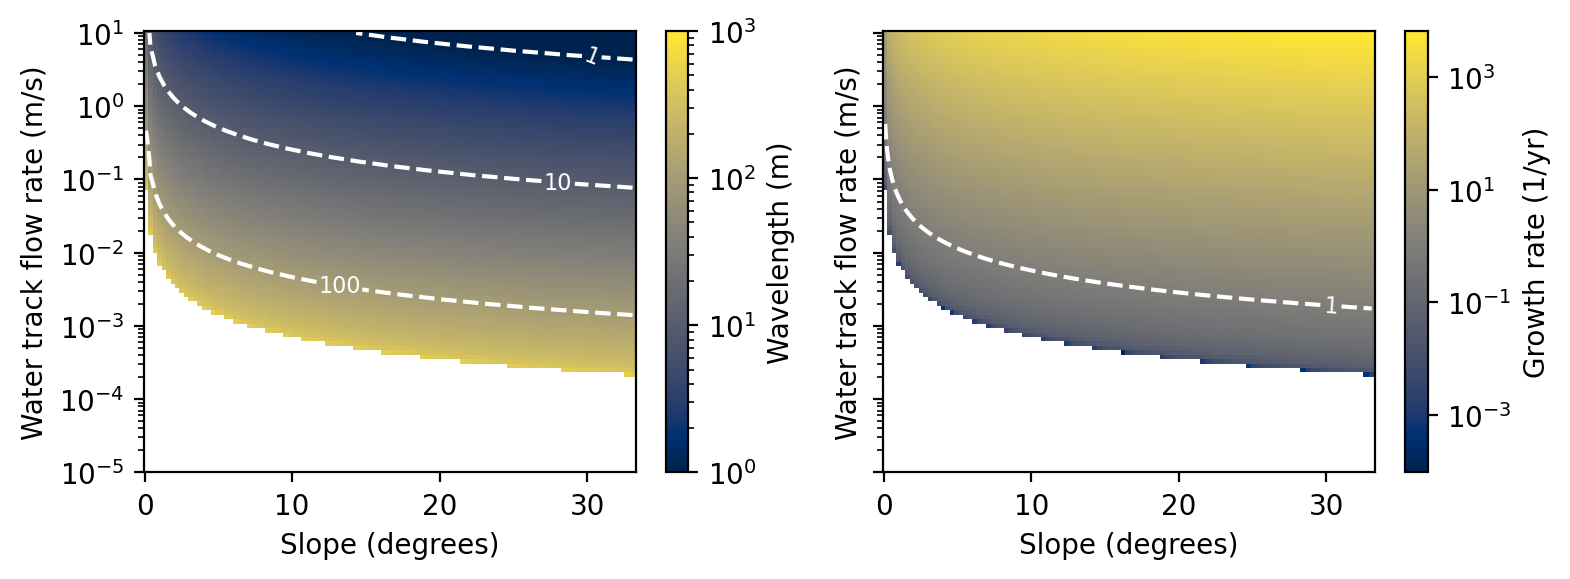

In [24]:
cmap_choose = 'cividis'

fig, ax = plt.subplots(
    1,2,  sharey=True, sharex=True,
    dpi=200,
    figsize=(8,3)
    )



im = ax[0].pcolormesh(np.rad2deg(ss), hh, 
                    np.ma.masked_where(np.array(sigma_max)<0, np.array(wavelength)), # mask where growth rate is negative 
             norm=colors.LogNorm(vmin=1e0, vmax=1e3),
             cmap=cmap_choose,
            #  alpha=0.75
             )
# im = ax[0].pcolormesh(np.rad2deg(ss), hh, 
#                     np.ma.masked_where(np.array(sigma_max * 3.15e7)<1, np.array(wavelength)), # mask where growth rate is negative 
#              norm=colors.LogNorm(vmin=1e0, vmax=1e3),
#              cmap=cmap_choose,
#              )
CS1 = ax[0].contour(np.rad2deg(ss), hh , wavelength, [1, 10, 100],  colors='white', linestyles='--')

ax[0].clabel(CS1, inline=True, fontsize=8)
ax[0].set_yscale('log')
plt.colorbar(im, label= f'Wavelength (m)')
ax[0].set_ylabel('Water track flow rate (m/s)')
ax[0].set_xlabel('Slope (degrees)')

im2 = ax[1].pcolormesh(np.rad2deg(ss), hh, sigma_max * 3.15e7, # in years
             norm=colors.LogNorm(
                 ),
             cmap=cmap_choose,
             )
ax[1].set_yscale('log')
CS1 = ax[1].contour(np.rad2deg(ss), hh , sigma_max * 3.15e7, [1],  colors='white', linestyles='--')
ax[1].clabel(CS1, inline=True, fontsize=8)
plt.colorbar(im2, label= f'Growth rate (1/yr)')
ax[1].set_ylabel('Water track flow rate (m/s)')
ax[1].set_xlabel('Slope (degrees)')

fig.tight_layout()
plt.savefig('figs/canonical.pdf', bbox_inches="tight")
plt.savefig('figs/canonical_jan25.png', bbox_inches="tight")



# Field data

In [25]:
def calc_one_wavelength(
    x_t = 1600,
    slope_deg = 5.0,
    porosity=0.9,
    frozen_grad = 10,
    unfrozen_grad = 30,
    beta = 0.04,
    flow_speed = 0.1
    ):
    # print(f'Using flow speed {flow_speed}')
    slope = np.tan(np.deg2rad(slope_deg))

    L_curly = 334E3 * porosity # Latent head of fusion modulated by porosity

    K_f = K_s*(1-porosity) + (K_i * porosity)

    # Calculate Q_bar, which is based on both
    Q_bar_calc = (flow_speed * rho_w * g * slope)

    growth_rate = (1/(rho_w*porosity*L_curly)) * (Q_bar_calc - (beta * unfrozen_grad))

    RHS = (2.0374 * (Q_bar_calc)) / (x_t**(2/3) * (K_f * frozen_grad))
    # print(f'Using RHS {RHS}')
    wavelength = get_wavelength(RHS, Q_bar_calc)
    return [wavelength, growth_rate]
    # return wavelength

In [26]:
flow_speed_list_toolik = np.logspace(-5,1, 1000)

data_list_toolik = []

for flow_speed in flow_speed_list_toolik:
    data_list_toolik.append(calc_one_wavelength(flow_speed=flow_speed))

wavelength_list_toolik = [item[0] for item in data_list_toolik]
growth_rate_list_toolik = [item[1] for item in data_list_toolik]

C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_8352\1597931246.py:9: RuntimeWarning: invalid value encountered in scalar power
  LHS_den = (kappa**2 + ((C_f*rho_f*(Q_bar_calc-(beta*unfrozen_grad)))/(K_f*rho_w*L_curly)))**(0.5)


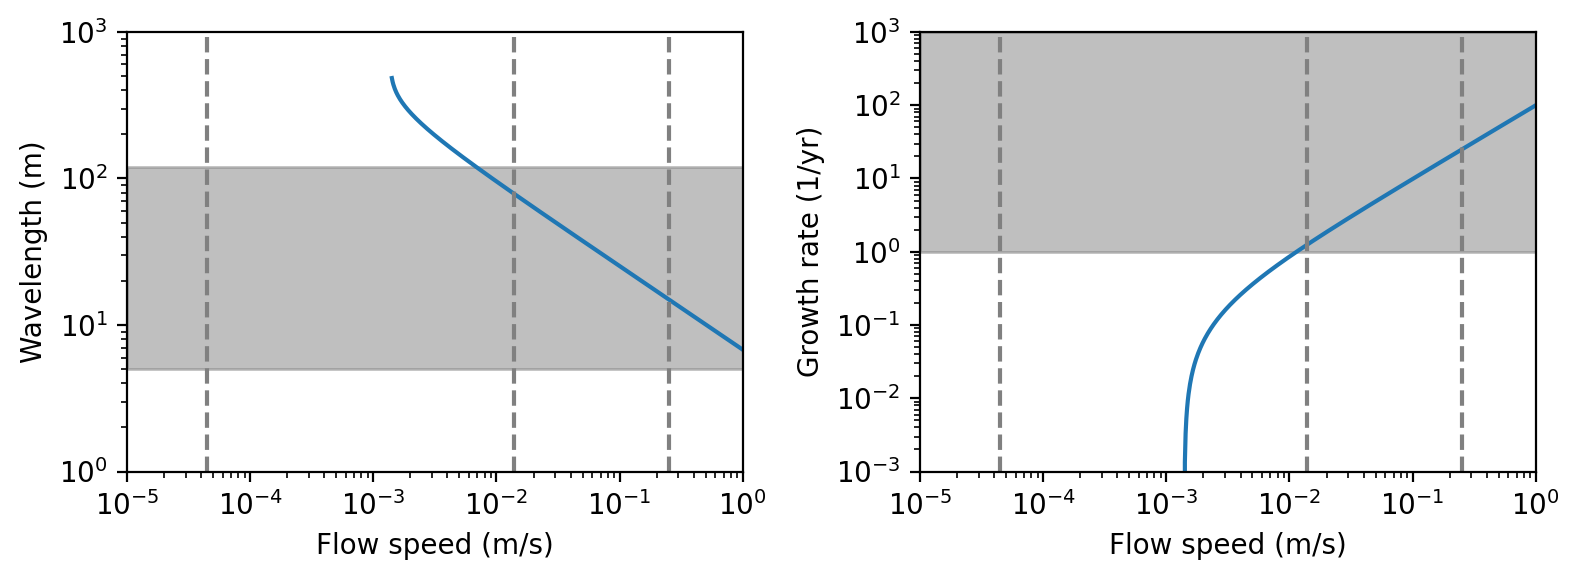

In [27]:
fig, ax = plt.subplots(
    1,2,  
    # sharey=True, 
    sharex=True,
    dpi=200,
    figsize=(8,3)
    )

x = flow_speed_list_toolik
# y = wavelength_list
y0 = np.ma.masked_where(np.array(growth_rate_list_toolik)<0, np.array(wavelength_list_toolik))

ax[0].set_xlabel("Flow speed (m/s)")
ax[0].set_ylabel("Wavelength (m)")

ax[0].plot(x,y0, zorder=2)

# ax[0].fill_betweenx(np.arange(1e0,1e5),
#   (flow_speed_aug), # august low flow in Q_bar form
#    (flow_speed_june), # june high flow in Q_bar form
#     color='gray', alpha=0.5)
ax[0].vlines([flow_speed_aug, flow_speed_june, 0.25], 1e0, 1e3, color='grey', linestyles='--')
ax[0].fill_between(np.arange(1e-5,2e1), 5, 120, color='gray', alpha=0.5)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_ylim(1e0,1e3)
ax[0].set_xlim(1e-5,1e0)


y1 = np.array(growth_rate_list_toolik)* 3.15e7

ax[1].set_xlabel("Flow speed (m/s)")
ax[1].set_ylabel("Growth rate (1/yr)")

ax[1].plot(x,y1, zorder=2)

# ax[1].fill_betweenx(np.arange(1e-3,1e3),
#   (flow_speed_aug), # august low flow in Q_bar form
#    (flow_speed_june), # june high flow in Q_bar form
#     color='gray', alpha=0.5)
ax[1].fill_between(np.arange(1e-5,2e1), 1, 1e3, color='gray', alpha=0.5)

ax[1].vlines([flow_speed_aug, flow_speed_june, 0.25], 1e-3, 1e3, color='grey', linestyles='--')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_ylim(1e-3, 1e3,)
ax[1].set_xlim(1e-5,1e0)

fig.tight_layout()

# Param sensitivity

In [28]:
param_steps = 500

params={
        'slope_deg':{
        'name':'Slope (degrees)',
        'range': np.linspace(0.01,20,param_steps)
    },        
    'beta':{
        'name':'β (W/mK)',
        'range': list(np.logspace(-1,-5,param_steps)*3) + [0.]
    },
    'x_t':{
        'name':'Hillslope length (m)',
        'range': np.linspace(100,2000,param_steps)
    },
        'frozen_grad':{
        'name':'Frozen gradient (C/m)',
        'range': np.linspace(5,25,param_steps)
    },

}

bless me father for i have sinned with this spaghetti ass code

In [29]:
flow_speed_list_sensitivity = np.logspace(-5,0,6)

In [30]:
flow_speed_data = {}
for flow_speed in flow_speed_list_sensitivity:
    x_axis_data = []
    for val in params['slope_deg']['range']:
        x_axis_data.append(calc_one_wavelength(flow_speed=flow_speed,slope_deg=val))
    flow_speed_data[flow_speed] = x_axis_data
params['slope_deg']['output']=flow_speed_data

flow_speed_data = {}
for flow_speed in flow_speed_list_sensitivity:
    x_axis_data = []
    for val in params['x_t']['range']:
        x_axis_data.append(calc_one_wavelength(flow_speed=flow_speed,x_t=val))
    flow_speed_data[flow_speed] = x_axis_data
params['x_t']['output']=flow_speed_data

flow_speed_data = {}
for flow_speed in flow_speed_list_sensitivity:
    x_axis_data = []
    for val in params['frozen_grad']['range']:
        x_axis_data.append(calc_one_wavelength(flow_speed=flow_speed,frozen_grad=val))
    flow_speed_data[flow_speed] = x_axis_data
params['frozen_grad']['output']=flow_speed_data

flow_speed_data = {}
for flow_speed in flow_speed_list_sensitivity:
    x_axis_data = []
    for val in params['beta']['range']:
        x_axis_data.append(calc_one_wavelength(flow_speed=flow_speed,beta=val))
    flow_speed_data[flow_speed] = x_axis_data
params['beta']['output']=flow_speed_data

C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_8352\1597931246.py:9: RuntimeWarning: invalid value encountered in scalar power
  LHS_den = (kappa**2 + ((C_f*rho_f*(Q_bar_calc-(beta*unfrozen_grad)))/(K_f*rho_w*L_curly)))**(0.5)


C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_8352\2134413188.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[3].legend(title="log(Flow speed)", loc='upper right',


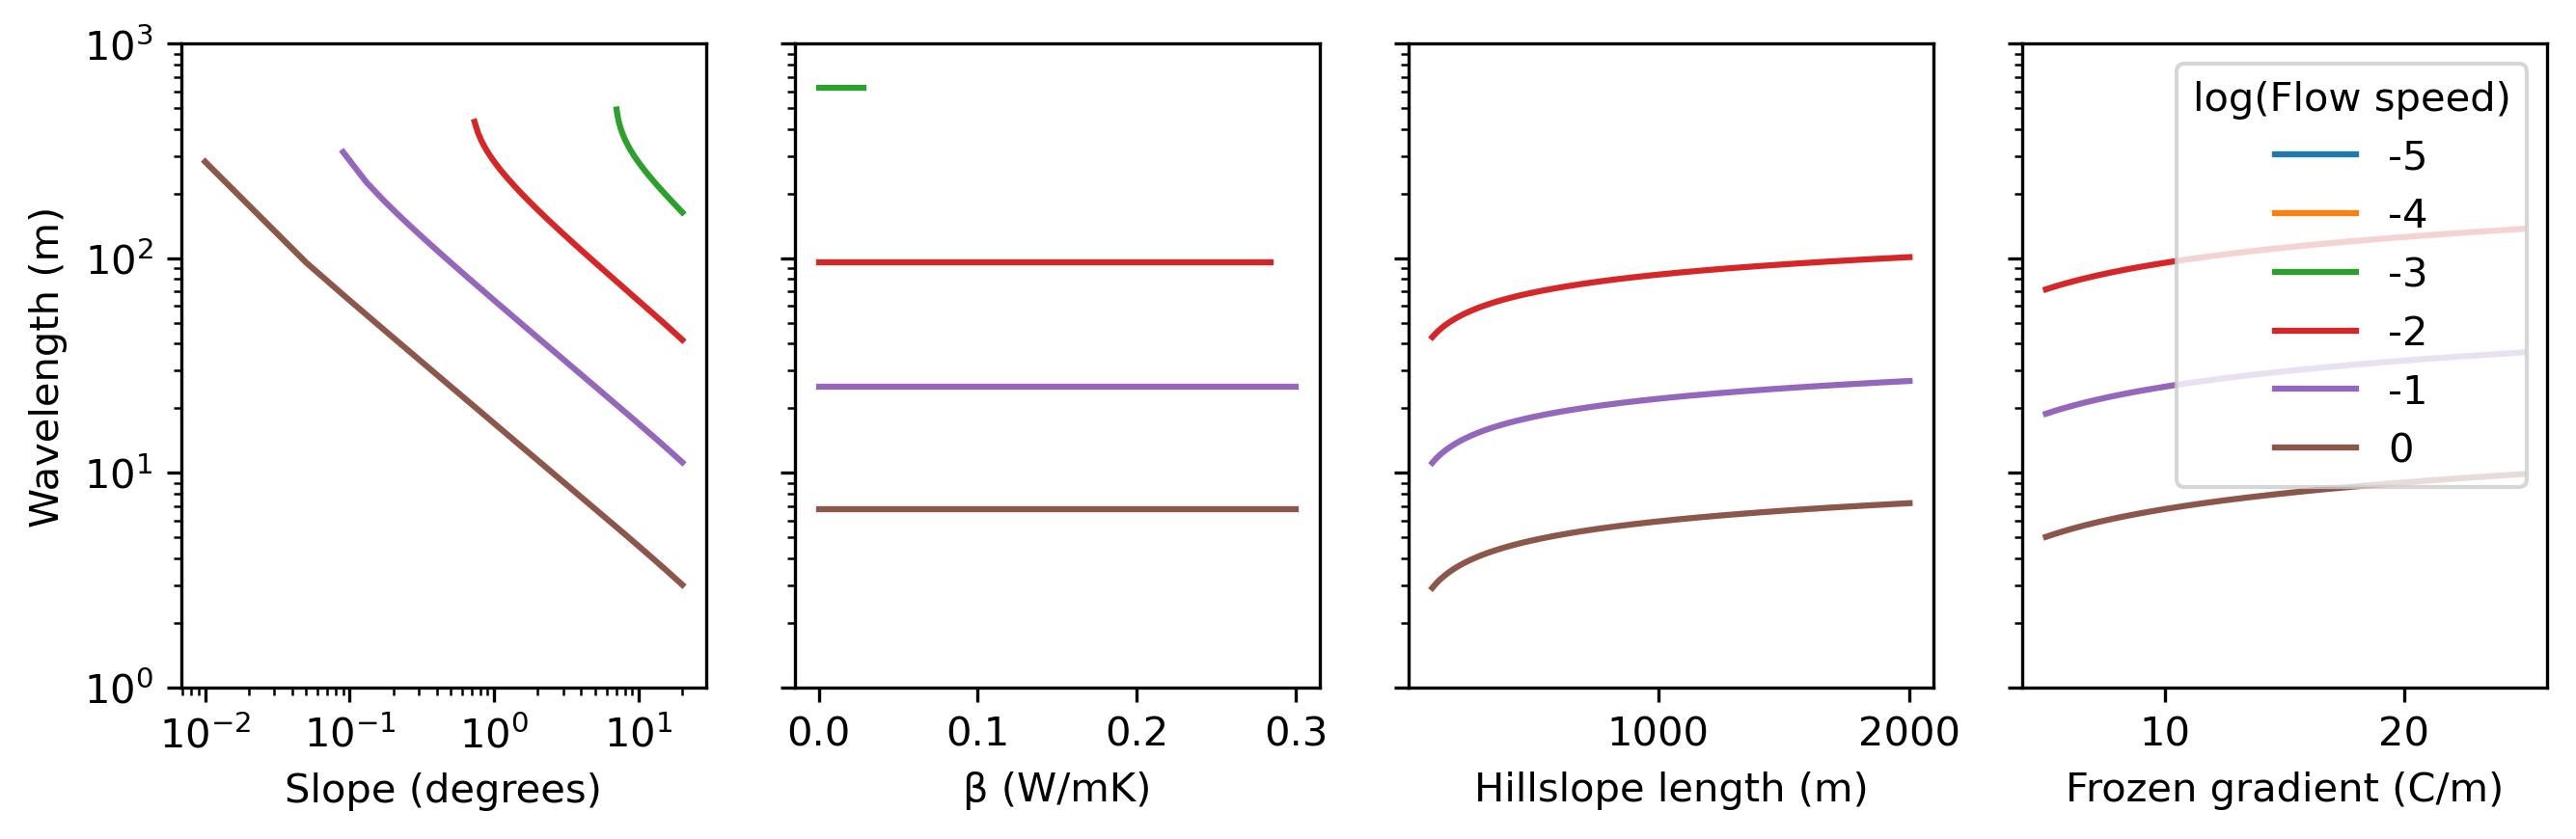

In [31]:
fig, ax = plt.subplots(1,4, figsize=(9,3), sharey=True, dpi=300)
for i, param in enumerate(params.keys()):
    # print(param)
    for speed in flow_speed_list_sensitivity:
        im = ax[i].plot(params[param]['range'], 
        np.ma.masked_where(np.array([item[1] for item in params[param]['output'][speed]])<0, [item[0] for item in params[param]['output'][speed]]),
         label=str(int(np.log10(speed)))
         )
        ax[i].set_xlabel(params[param]['name'])
        ax[3].legend(title="log(Flow speed)", loc='upper right', 
                    #  ncols=2
                     )

ax[0].set_ylim(1e0,1e3)
ax[0].set_yscale("log")
ax[0].set_ylabel("Wavelength (m)")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
fig.tight_layout()

plt.savefig('figs/param_sensitivity_wavelength.png', bbox_inches="tight")

C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_8352\2365612065.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[3].legend(title="log(Flow speed)", loc='upper right',


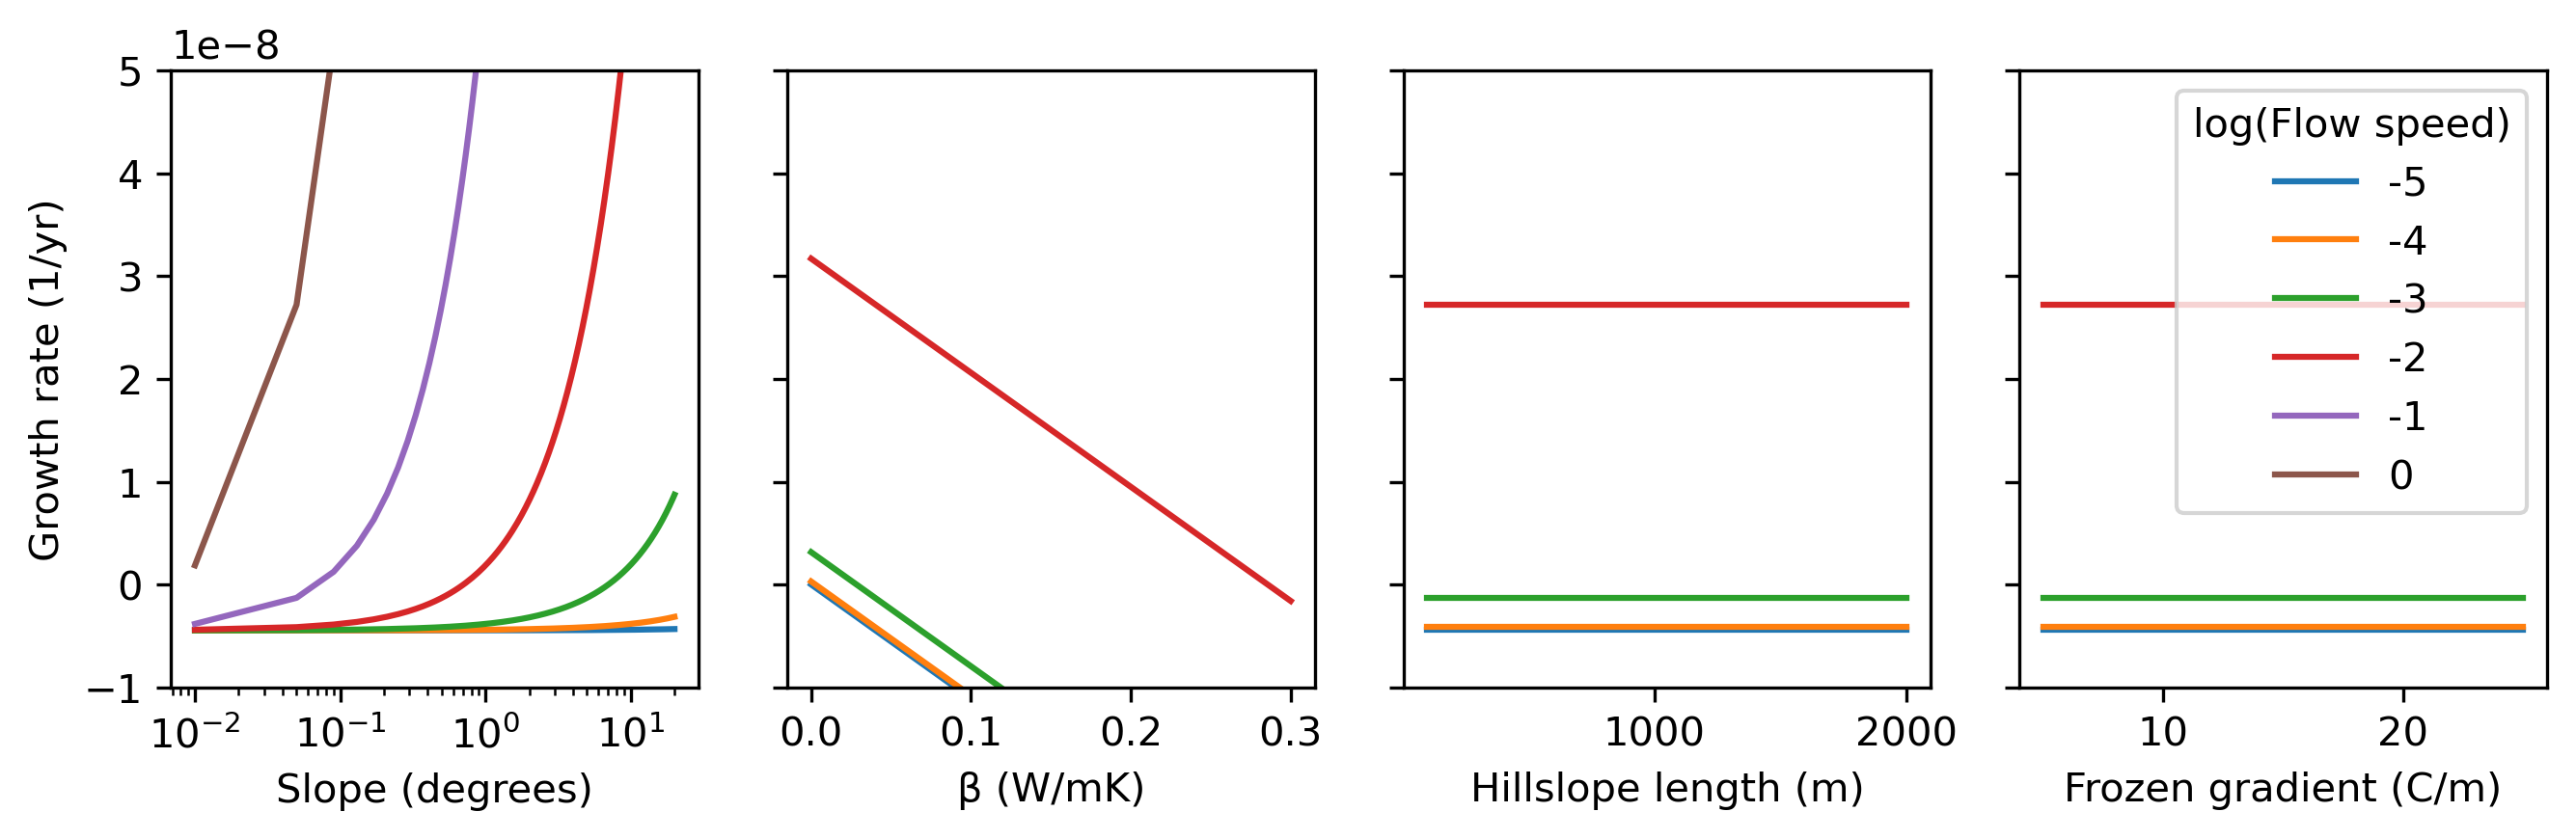

In [32]:
fig, ax = plt.subplots(1,4, figsize=(9,3), sharey=True, dpi=300)
for i, param in enumerate(params.keys()):
    # print(param)
    for speed in flow_speed_list_sensitivity:
        # print(por)
        # print(params[param]['range'])
        im = ax[i].plot(params[param]['range'], [item[1] for item in params[param]['output'][speed]],
         label=str(int(np.log10(speed)))
         )
        ax[i].set_xlabel(params[param]['name'])
        ax[3].legend(title="log(Flow speed)", loc='upper right', 
                    #  ncols=2
                     )

ax[0].set_ylim(-1e-8,5e-8)
ax[0].set_ylabel("Growth rate (1/yr)")
ax[0].set_xscale("log")
fig.tight_layout()

plt.savefig('figs/param_sensitivity_growthrate.png', bbox_inches="tight")